In [220]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [221]:
#Import data frame
path1 = r"/Users/shuhui_zhao/Desktop/credit_card_approval_prediction/credit_record.csv"
path2 = r"/Users/shuhui_zhao/Desktop/credit_card_approval_prediction/application_record.csv"
#
credit_df=pd.read_csv(path1)
#clients' application info
app_df=pd.read_csv(path2)

In [222]:
print(credit_df.shape)
credit_df.head()
print(credit_df)

(1048575, 3)
              ID  MONTHS_BALANCE STATUS
0        5001711               0      X
1        5001711              -1      0
2        5001711              -2      0
3        5001711              -3      0
4        5001712               0      C
...          ...             ...    ...
1048570  5150487             -25      C
1048571  5150487             -26      C
1048572  5150487             -27      C
1048573  5150487             -28      C
1048574  5150487             -29      C

[1048575 rows x 3 columns]


In [223]:
######Response variable
###Check missing value
credit_df = credit_df.dropna()
print(credit_df.shape) #apparantly, there is no missing data
#sort the data by customers' ID
credit_df.sort_values('ID')
###Check duplicates
#For each id, if there are two identical month, delete both observations
#temporary data frame: groups_month, groups_month_count
groups_month = credit_df.groupby(['ID','MONTHS_BALANCE'])
groups_month_count = groups_month.count()
groups_month_count = groups_month_count.rename(columns = {"STATUS":"COUNT"})
print(groups_month_count.loc[groups_month_count['COUNT']>1]) #no replicates


(1048575, 3)
Empty DataFrame
Columns: [COUNT]
Index: []


In [224]:
###Vintage analysis
#credit_df['MONTHS_BALANCE'].max()
#credit_df['MONTHS_BALANCE'].min()
#we are going to dig in the past 60 months, every 6 months
credit_grouped = credit_df.groupby('ID')

In [225]:
#reshape data by 'ID' based on 'MONTHS_BALANCE'
credit_pivot = credit_df.pivot(index = 'ID', columns = 'MONTHS_BALANCE', values = 'STATUS')
#print(credit_pivot.head())
#assume that the minimum value of 'MONTHS_BALANCE' is the open_month
#Similarly, assume that the maximum value of 'MONTHS_BALANCE' is the close_month
#group the credit_df by 'ID' and extract the minimum & maximum value of 'MONTHS_BALANCE'
credit_grouped = credit_df.groupby('ID')
credit_pivot['open_month'] = credit_grouped['MONTHS_BALANCE'].min()
credit_pivot['close_month'] = credit_grouped['MONTHS_BALANCE'].max()
credit_pivot['ID'] = credit_pivot.index
credit_pivot = credit_pivot[['ID','open_month','close_month']]
#to merge the data, 'ID' cannot be an index level
credit_pivot.reset_index(drop=True, inplace=True)
#calculate the window_month
credit_pivot["window_month"] = credit_pivot['close_month']-credit_pivot['open_month']

In [227]:
#According to IFRS 9, consider 12 months as performance window
credit_pivot = credit_pivot[credit_pivot['window_month']>12]

In [228]:
#merge two data frame (LEFT OTTER JOIN)
credit = pd.merge(credit_df, credit_pivot, how = 'left', on = 'ID')
#save credit in credit0 in case further use
credit0 = credit
print(credit.head())

        ID  MONTHS_BALANCE STATUS  open_month  close_month  window_month
0  5001711               0      X         NaN          NaN           NaN
1  5001711              -1      0         NaN          NaN           NaN
2  5001711              -2      0         NaN          NaN           NaN
3  5001711              -3      0         NaN          NaN           NaN
4  5001712               0      C       -18.0          0.0          18.0


In [229]:
###calculate the cumulative percentage of bad customers (cumulative charge-off rate/cumulative loss rate)

#denominator: number of customers who opened their account every months
de = credit_pivot.groupby('open_month').agg({'ID':'count'})
#after groupby, reset_index is needed normally
de.reset_index(inplace=True)
de = de.rename(columns = {"ID":"open_sum"})

#A customer will be considered as 'bad' (1) if overdue

credit['overdue']=np.where((credit['STATUS']=='2')|(credit['STATUS']=='3')
                           |(credit['STATUS']=='4')|(credit['STATUS']=='5'),1,0)
#month on balance
credit['MOB']=credit['MONTHS_BALANCE']-credit['open_month']
credit.sort_values(['ID','MOB'],inplace=True)

In [230]:
#calculate the cumulative charge-off rate
#group by MOB and open_month, count for a certain MOB and open_month, how many customors in total
vintage = credit.groupby(['open_month','MOB']).agg({'ID':'count'})
vintage.reset_index(inplace=True)
vintage['overdue_count'] = np.nan
vintage = vintage[['open_month','MOB','overdue_count']]
vintage = pd.merge(vintage,de,how='left',on='open_month')
print(vintage)

      open_month   MOB  overdue_count  open_sum
0          -60.0   0.0            NaN       368
1          -60.0   1.0            NaN       368
2          -60.0   2.0            NaN       368
3          -60.0   3.0            NaN       368
4          -60.0   4.0            NaN       368
...          ...   ...            ...       ...
1795       -13.0   9.0            NaN       841
1796       -13.0  10.0            NaN       841
1797       -13.0  11.0            NaN       841
1798       -13.0  12.0            NaN       841
1799       -13.0  13.0            NaN       841

[1800 rows x 4 columns]


In [231]:
#loop to count overdue
# for i in range(-60,1):
#     ls = [] #to save 
#     for j in range(0,61):
#         #save the ID number
#         due = list(credit[(credit['open_month']==i) & (credit['MOB']==j) & (credit['overdue']==1)]['ID'])
#         ls.extend(*due)
#         # calculate non-duplicate ID numbers
#         vintage.loc[(vintage['open_month'] == i) & (vintage['MOB'] == j),'overdue_count'] = len(set(ls))

In [252]:
#loop to count overdue
#divide 48 months into 8 period of half a year
for i in range(-60,1,6):
    ls = [] #to save 
    lst = [k for k in range(i,i+6)]
    for j in range(0,61):
        #save the ID number
        due = list(credit[(credit['open_month']==i) & (credit['MOB']==j) & (credit['overdue']==1)]['ID'])
        ls.extend(due)
        # calculate non-duplicate ID numbers
        vintage.loc[(vintage['open_month'] == i) & (vintage['MOB'] == j),'overdue_count'] = len(set(ls))

In [253]:
#vintage['rate'] = vintage['overdue_count']/vintage['open_sum']
#vintage_tb = vintage.pivot(index='open_month',columns='MOB',values='rate')
#print(vintage_tb.head())
###every 6 months as a open_month group
print(vintage.head())

   open_month  MOB  overdue_count  open_sum  rate
0       -60.0  0.0            0.0       368   0.0
1       -60.0  1.0            0.0       368   0.0
2       -60.0  2.0            0.0       368   0.0
3       -60.0  3.0            0.0       368   0.0
4       -60.0  4.0            0.0       368   0.0


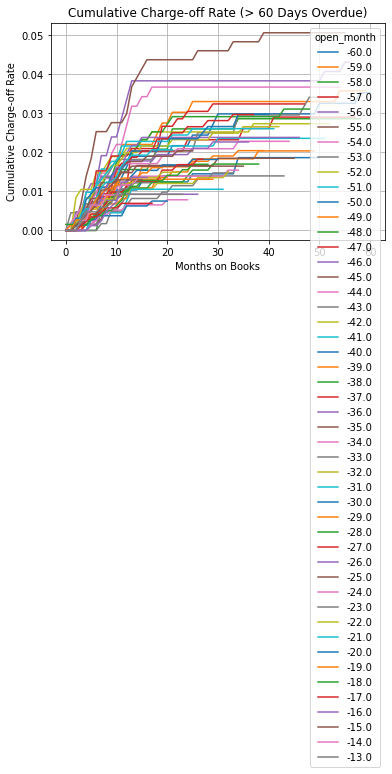

In [236]:
# plot vintage line chart
plt.rcParams['figure.facecolor'] = 'white'
#replace NaN into 0
vintage_graph = vintage_tb.replace(0,np.nan)
lst = [i for i in range(0,61)]
vintage_tb[lst].T.plot(legend = True, grid = True, title = 'Cumulative Charge-off Rate (> 60 Days Overdue)')
#plt.axvline(30)
#plt.axvline(25)
#plt.axvline(20)
plt.xlabel('Months on Books')
plt.ylabel('Cumulative Charge-off Rate')
plt.show()

In [ ]:
#
print(app_df.shape)
app_df.head()

In [ ]:
#Join two data frames by ID
sum_df = pd.concat([credit_df,app_df])
#Sort the merged data frame by ID

